The goal of this notebook is to prepare and conduct an exploratory data analysis (EDA) specifically on the application dataset, using a mix of tabular and visual techniques. In this notebook, 3_1_cleaning_app_data, we’ll focus on identifying outliers and removing certain flag features without creating new features. This will serve as a solid baseline for comparison with 3_2_cleaning_app_data, where we’ll take it a step further by generating new features. This approach will help us better understand the impact of **feature engineering** on model performance.


In [3]:
import pandas as pd
import numpy as np

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# import the functions from the file
from notebook_setup import RootPath, config
from my_functions import pie_plot

# Automatically Reload Changes if there are frequent changes to my xx.py file
%load_ext autoreload
%autoreload 2

In [4]:

# import the functions from the file
from my_functions import (
    convert_to_categorical, 
    encode_and_one_hot, 
    summarize_dataframe,
    detect_outliers_iqr_all, 
    winsorize_selected_features, 
    plot_histogram,
    plot_selected_histograms, 
    transform_to_log, 
    plot_qq_hist,
    kolmogorov_smirnov_test, 
    box_cox_transform, 
    apply_robust_scaling,
    get_top_correlations, 
    missing_values_table, 
    merge_data_on_index
)


In [5]:
# load the application sampled data
app_sample = pd.read_csv(f'{config.CleanDataPath}app_sample.csv', index_col='SK_ID_CURR')
# Drop any columns that contain "Unnamed" in their name
app_sample = app_sample.loc[:, ~app_sample.columns.str.contains('^Unnamed')]
app_sample

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
307474,0,Cash loans,F,Y,N,0,67500.0,1030302.0,40860.0,832500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
412537,0,Cash loans,F,Y,Y,0,90000.0,253737.0,26775.0,229500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
149084,0,Cash loans,M,Y,Y,0,270000.0,1006920.0,45499.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,3.0
364692,0,Cash loans,M,Y,Y,2,202500.0,495351.0,29497.5,459000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
155423,0,Cash loans,M,Y,Y,0,162000.0,264159.0,13617.0,220500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356531,0,Cash loans,F,Y,Y,0,247500.0,675000.0,29731.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
336872,1,Cash loans,F,N,N,0,270000.0,634482.0,20596.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
375274,0,Cash loans,F,N,N,0,202500.0,1288350.0,37800.0,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


TARGET
0    28270
1     2481
Name: count, dtype: int64


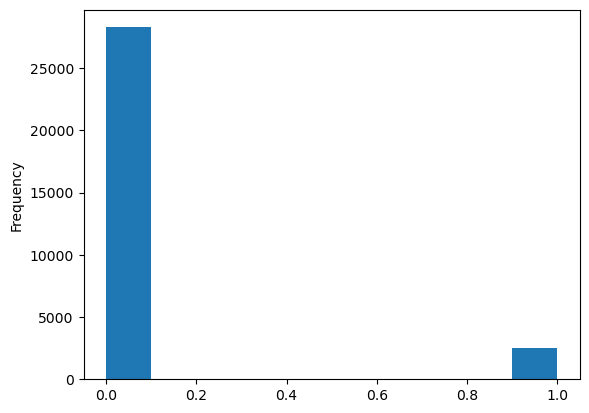

In [6]:
print(app_sample['TARGET'].value_counts())
app_sample['TARGET'].astype(int).plot.hist();

In [7]:
df1 = app_sample.copy()
target = app_sample['TARGET']
summarize_dataframe(df1)



Data Total Number of Each Type:
 float64    65
int64      40
object     16
Name: count, dtype: int64

Float Types Count:
 AMT_INCOME_TOTAL               596
AMT_CREDIT                    2852
AMT_ANNUITY                   7338
AMT_GOODS_PRICE                447
REGION_POPULATION_RELATIVE      81
                              ... 
AMT_REQ_CREDIT_BUREAU_DAY        7
AMT_REQ_CREDIT_BUREAU_WEEK       6
AMT_REQ_CREDIT_BUREAU_MON       18
AMT_REQ_CREDIT_BUREAU_QRT        8
AMT_REQ_CREDIT_BUREAU_YEAR      14
Length: 65, dtype: int64

Integer Types Count:
 TARGET                             2
CNT_CHILDREN                       8
DAYS_BIRTH                     13789
DAYS_EMPLOYED                   6912
DAYS_ID_PUBLISH                 5538
FLAG_MOBIL                         1
FLAG_EMP_PHONE                     2
FLAG_WORK_PHONE                    2
FLAG_CONT_MOBILE                   2
FLAG_PHONE                         2
FLAG_EMAIL                         2
REGION_RATING_CLIENT               3


In [8]:
#dropping flag columns
flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
            'FLAG_DOCUMENT_20']
df1 = df1.drop(columns = flag_cols_to_drop)

This code snippet:
1. Identifies columns with `dtype: object` in `application_data`.
2. Converts these columns to categorical data types.
3. Applies one-hot encoding to these columns, creating new binary columns for each category. The resulting DataFrame, `df2`, contains the one-hot encoded features.

In [10]:
df2 = convert_to_categorical(df1)
df2 = encode_and_one_hot(df2)

Converted columns to categorical: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
DataFrame shape before encoding: (30751, 116)
0 columns were label encoded.
DataFrame shape after encoding: (30751, 221)


In [11]:
pd.options.display.max_columns = 200
print(df2.shape)
df2.describe()

(30751, 221)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_11,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,30751.000000,30751.000000,3.075100e+04,3.075100e+04,30751.000000,3.073000e+04,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,10427.000000,30751.0,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30750.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,13250.000000,30666.000000,24717.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15230.000000,12772.000000,15836.000000,10317.000000,9279.000000,14430.000000,15330.000000,15529.000000,9901.000000,12515.000000,9774.000000,15357.000000,9402.000000,13786.000000,15979.000000,30649.000000,30649.000000,30649.000000,30649.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,26694.000000,26694.000000,26694.000000,26694.000000,26694.000000,26694.000000
mean,0.080680,0.412117,1.694801e+05,5.959022e+05,27031.693164,5.355089e+05,0.020777,-16090.213391,65289.421092,-5016.161296,-3008.758902,11.959816,1.0,0.815811,0.199701,0.997919,0.278105,0.057494,2.150016,2.049689,2.029300,12.071087,0.015512,0.050307,0.040942,0.078274,0.228643,0.177035,0.502691,0.514601,0.510544,0.117145,0.088700,0.977565,0.753168,0.044027,0.078657,0.150571,0.225978,0.232015,0.066412,0.100614,0.107700,0.008433,0.029231,0.114057,0.087826,0.976770,0.760425,0.042121,0.074053,0.146110,0.222069,0.228070,0.064962,0.105629,0.106110,0.007707,0.027829,0.117514,0.088316,0.977574,0.756454,0.044036,0.077663,0.149994,0.225535,0.231649,0.067236,0.101906,0.108835,0.008240,0.029143,0.102627,1.438155,0.143333,1.420634,0.099905,-968.849989,0.705896,0.014731,0.090339,0.000228,0.082599,0.003415,0.004162,0.003512,0.002732,0.001561,0.009105,0.000260,0.008357,0.000683,0.000683,0.0

Based on the statistical summary, we observe that the 'DAYS_BIRTH' and 'DAYS_EMPLOYED' features have negative values. To improve interpretability, we'll transform these values to positive and convert them to years. Additionally, we noticed that 'DAYS_EMPLOYED' has an unusually large maximum value of 365243, likely indicates data errors or extreme outliers. Therefore, we'll replace these extreme values with missing values to ensure data quality. We also remove high values in the 'OBS_30_CNT_SOCIAL_CIRCLE' and 'OBS_60_CNT_SOCIAL_CIRCLE' columns by replacing them with NaN. Although these extreme values did not appear in this random sample, it’s important to address them for data consistency.


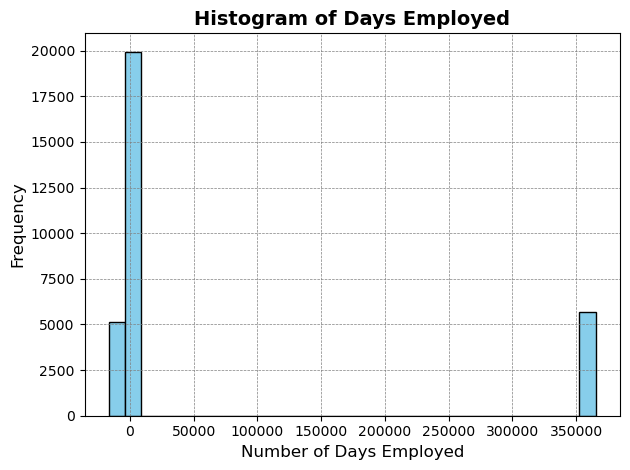

In [13]:
plot_histogram(df2, column='DAYS_EMPLOYED', title='Days Employed', xlabel='Number of Days Employed')

In [14]:
# Count values greater than 30 in the column 'OBS_30_CNT_SOCIAL_CIRCLE'
#count_greater_than_30 = (df2['OBS_60_CNT_SOCIAL_CIRCLE'] > 30).sum()
#print(count_greater_than_30)

In [15]:
# change days birth to positive values
df2['DAYS_BIRTH'] = df2['DAYS_BIRTH'] * (-1/ 365)
df2['DAYS_EMPLOYED'] = df2['DAYS_EMPLOYED'] * (-1/ 365)

# Create an anomalous flag column for this extreme case
df2['DAYS_EMPLOYED_ANOM'] = df2["DAYS_EMPLOYED"] >= df2["DAYS_EMPLOYED"].min()

# removing anomalous points
df2['DAYS_EMPLOYED'].replace({df2["DAYS_EMPLOYED"].min(): np.nan}, inplace = True)
df2.loc[df2['OBS_30_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_30_CNT_SOCIAL_CIRCLE'] = np.nan
df2.loc[df2['OBS_60_CNT_SOCIAL_CIRCLE'] > 30, 'OBS_60_CNT_SOCIAL_CIRCLE'] = np.nan

df2[['DAYS_BIRTH', 'DAYS_EMPLOYED', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE']].describe()


,DAYS_BIRTH,DAYS_EMPLOYED,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
count,30751.000000,25089.000000,30649.000000,30649.000000
mean,44.082776,6.583781,1.438155,1.420634
std,11.995982,6.451045,2.351176,2.329988
min,21.035616,0.010959,0.000000,0.000000
25%,34.158904,2.112329,0.000000,0.000000
50%,43.309589,4.528767,0.000000,0.000000
75%,54.100000,8.775342,2.000000,2.000000
max,69.019178,44.863014,25.000000,25.000000


Now, we can clearly see the distribution of the 'DAYS_EMPLOYED' feature. Displaying it in terms of years employed provides a clearer and more meaningful understanding of its distribution.

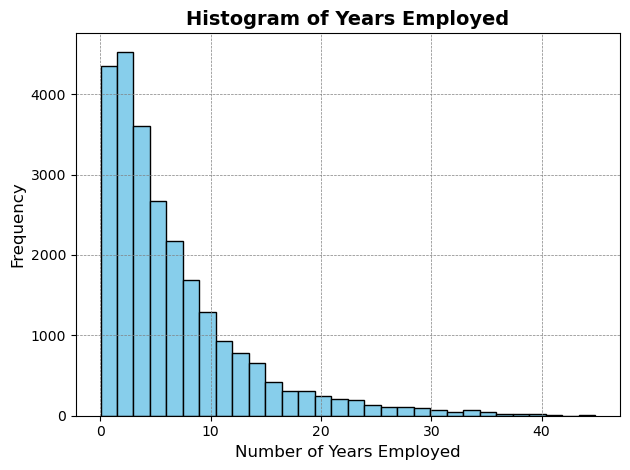

In [17]:
plot_histogram(df2, column='DAYS_EMPLOYED', title='Years Employed', xlabel='Number of Years Employed')

We can now use the `get_top_correlations` function to analyze the correlation of all features with the 'TARGET' label. This function identifies the top 30 features with the strongest positive and negative correlations, resulting in a set of 60 highly relevant features. The top 30 features with positive correlation to the 'TARGET' label range from 0.016662 to 0.063799, while the top 30 features with negative correlation range from -0.026089 to -0.186173. Although these correlations are not particularly strong, they represent the best predictive features available within the application dataset.

We’ll store these top 60 features in one dataset and keep the remaining features in another, along with all features from other datasets. To improve computational efficiency, speed, and reduce noise, we’ll apply Factor Analysis of Mixed Data (FAMD) to reduce the dimensionality of this combined dataset until we reach an accumulative variance of 70%.


In [19]:
target = app_sample['TARGET']
df2 = df2.drop(columns = 'TARGET')
top15_corr_column_names = get_top_correlations(df2, target,top_n=30)


Most Positive Correlations (Top 30):

 NAME_INCOME_TYPE_Working                             0.063799
REGION_RATING_CLIENT_W_CITY                          0.063421
DAYS_ID_PUBLISH                                      0.062250
REGION_RATING_CLIENT                                 0.059778
FLAG_DOCUMENT_3                                      0.056257
DAYS_REGISTRATION                                    0.053531
REG_CITY_NOT_WORK_CITY                               0.052241
DAYS_LAST_PHONE_CHANGE                               0.051834
FLAG_EMP_PHONE                                       0.050509
REG_CITY_NOT_LIVE_CITY                               0.048812
CODE_GENDER_M                                        0.048756
NAME_EDUCATION_TYPE_Secondary / secondary special    0.046829
OCCUPATION_TYPE_Laborers                             0.043765
NAME_HOUSING_TYPE_With parents                       0.040916
OCCUPATION_TYPE_Drivers                              0.030542
LIVE_CITY_NOT_WORK_CITY        

In [20]:
# data to predict the model
df3 = df2[top15_corr_column_names]
df4 = df2.drop(columns = top15_corr_column_names)
y_target = app_sample[['TARGET']]
y_target

,TARGET
SK_ID_CURR,
307474,0
412537,0
149084,0
364692,0
155423,0
...,...
356531,0
336872,1
375274,0


In [21]:
# Missing values statistics
missing_values = missing_values_table(df4)
missing_values.head(20)

Number of columns of this dataframe is 161.
Columns with missing values are 38.


,Missing Values,% of Total Values
COMMONAREA_MODE,21472,69.8
COMMONAREA_AVG,21472,69.8
COMMONAREA_MEDI,21472,69.8
NONLIVINGAPARTMENTS_MODE,21349,69.4
NONLIVINGAPARTMENTS_MEDI,21349,69.4
NONLIVINGAPARTMENTS_AVG,21349,69.4
LIVINGAPARTMENTS_MEDI,20977,68.2
LIVINGAPARTMENTS_AVG,20977,68.2
LIVINGAPARTMENTS_MODE,20977,68.2
LANDAREA_MEDI,18236,59.3


In [22]:
# Save two data for model prediction
df3.to_csv(f'{config.CleanDataPath}df3.csv', index=True, index_label='SK_ID_CURR')
df4.to_csv(f'{config.CleanDataPath}df4.csv', index=True, index_label='SK_ID_CURR')
y_target.to_csv(f'{config.CleanDataPath}y_target.csv', index=True, index_label='SK_ID_CURR')